<h1>Content Based Image Retrieval<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-dependencies" data-toc-modified-id="Import-dependencies-1">Import dependencies</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2">Load data</a></span></li><li><span><a href="#Train---test-split" data-toc-modified-id="Train---test-split-3">Train - test split</a></span></li><li><span><a href="#Grey-Level-Co-occurrence-Matrices-(GLCM)-for-Texture-Description" data-toc-modified-id="Grey-Level-Co-occurrence-Matrices-(GLCM)-for-Texture-Description-4">Grey Level Co-occurrence Matrices (GLCM) for Texture Description</a></span><ul class="toc-item"><li><span><a href="#Grayscale-conversion" data-toc-modified-id="Grayscale-conversion-4.1">Grayscale conversion</a></span></li><li><span><a href="#Building-the-GLCM-vectors-from-scratch" data-toc-modified-id="Building-the-GLCM-vectors-from-scratch-4.2">Building the GLCM vectors from scratch</a></span></li><li><span><a href="#Building-the-GLCM-vectors-using-already-existent-implementations" data-toc-modified-id="Building-the-GLCM-vectors-using-already-existent-implementations-4.3">Building the GLCM vectors using already existent implementations</a></span></li><li><span><a href="#GCLM-characterization" data-toc-modified-id="GCLM-characterization-4.4">GCLM characterization</a></span><ul class="toc-item"><li><span><a href="#Maximum-probability" data-toc-modified-id="Maximum-probability-4.4.1">Maximum probability</a></span></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-4.4.2">Correlation</a></span></li><li><span><a href="#Contrast" data-toc-modified-id="Contrast-4.4.3">Contrast</a></span></li><li><span><a href="#Uniformity-(Energy)" data-toc-modified-id="Uniformity-(Energy)-4.4.4">Uniformity (Energy)</a></span></li><li><span><a href="#Homogenity" data-toc-modified-id="Homogenity-4.4.5">Homogenity</a></span></li><li><span><a href="#Entropy" data-toc-modified-id="Entropy-4.4.6">Entropy</a></span></li><li><span><a href="#Dissimilarity" data-toc-modified-id="Dissimilarity-4.4.7">Dissimilarity</a></span></li></ul></li></ul></li><li><span><a href="#Building-feature-vectors-for-CBIR" data-toc-modified-id="Building-feature-vectors-for-CBIR-5">Building feature vectors for CBIR</a></span></li><li><span><a href="#Defining-a-similarity-/-distance-measure" data-toc-modified-id="Defining-a-similarity-/-distance-measure-6">Defining a similarity / distance measure</a></span></li><li><span><a href="#CBIR---train-stage" data-toc-modified-id="CBIR---train-stage-7">CBIR - train stage</a></span></li><li><span><a href="#CBIR---test-stage" data-toc-modified-id="CBIR---test-stage-8">CBIR - test stage</a></span></li></ul></div>

## Import dependencies

In [2]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import os
import warnings
import numpy as np
import cv2
import random
import re
import pandas as pd
import math
import tqdm


from skimage.feature.texture import greycomatrix
from scipy.spatial import distance
from collections import Counter

warnings.filterwarnings("ignore")

## Load data

In [3]:
len(os.listdir('./Corel1000'))

1001

In [4]:
sorted(os.listdir('./Corel1000'))[1:10]

['000.jpg',
 '001.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '007.jpg',
 '008.jpg']

In [5]:
# get grayscale image
def get_grayscale(filename):
    image = img.imread(filename)
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image_grayscale # grayscale 1 value [0, 255] per pixel

def get_grayscale_rgb_format(filename):
    gray = cv2.imread(filename, 0)
    image = cv2.merge([gray, gray, gray])
    return image # grayscale in rgb format

Shape:  (384, 256, 3)


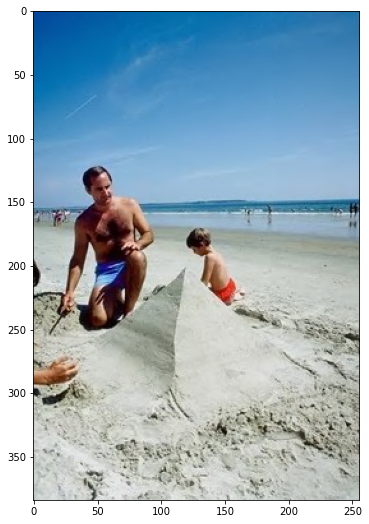

In [6]:
def visualize_image(image, title=None):
    fig = plt.figure(figsize=(15,9))
    
    if len(list(image.shape)) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
    plt.imshow(np.uint8(image))
    if title != None:
        plt.title(title, fontdict = {'fontsize' : 20})
    plt.show()
    
def see_test_image(filename):
    image = img.imread(filename)
    print('Shape: ', image.shape)

    visualize_image(image)
     
see_test_image('./Corel1000/101.jpg')

## Train - test split

In [7]:
def get_data():
    files = sorted(os.listdir('./Corel1000/'))
    files.remove('.gitkeep')
    return files
get_data()[:10]

['000.jpg',
 '001.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '007.jpg',
 '008.jpg',
 '009.jpg']

In [8]:
sorted(random.sample(range(10), 3))

[2, 4, 6]

In [9]:
def get_file_name_given_index_and_category(category, index_file):
    filename = str(category)
    if index_file // 10 == 0:
        filename += '0' + str(index_file) 
    else:
        filename += str(index_file) 
    filename += '.jpg'
    return filename

def get_test_set():
    files = get_data()
    FILES_PER_CATEGORY = 100
    test_data = []
    for category_index in range(0, len(files) // FILES_PER_CATEGORY):
        random_file_indexes = sorted(random.sample(range(100), 30))
        for index in random_file_indexes:
            test_data.append(get_file_name_given_index_and_category(category=category_index, index_file=index))
    return test_data

In [10]:
test_data = get_test_set()
len(test_data)

300

In [11]:
test_data[:10]

['001.jpg',
 '002.jpg',
 '011.jpg',
 '012.jpg',
 '019.jpg',
 '022.jpg',
 '026.jpg',
 '042.jpg',
 '043.jpg',
 '046.jpg']

In [12]:
train_data = [file for file in get_data() if file not in test_data]
train_data[:10]

['000.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '007.jpg',
 '008.jpg',
 '009.jpg',
 '010.jpg',
 '013.jpg']

## Grey Level Co-occurrence Matrices (GLCM) for Texture Description

### Grayscale conversion

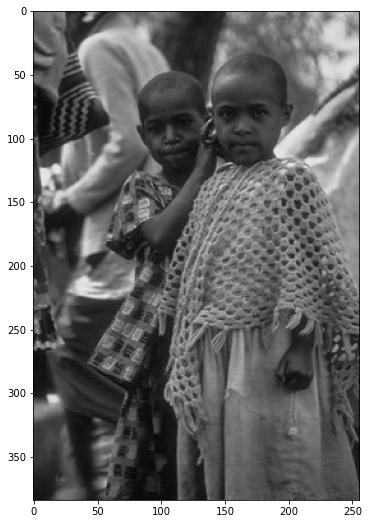

In [13]:
visualize_image(get_grayscale('./Corel1000/000.jpg'))

### Building the GLCM vectors from scratch

In [14]:
input_image = np.asarray([
    [0, 1, 2, 3, 3],
    [1, 2, 1, 0, 2],
    [2, 1, 3, 3, 0],
    [0, 0, 2, 2, 1],
    [1, 1, 2, 0, 2]])

displacement_vector = (1, 1)

def get_gray_levels_from_image(image):
    return list(set(image.reshape(-1,)))

def initialize_p_element(image):
    gray_levels = get_gray_levels_from_image(image)
    return np.zeros(shape=(max(gray_levels) + 1, max(gray_levels) + 1))

In [15]:
"The gray levels are " + str(get_gray_levels_from_image(input_image))

'The gray levels are [0, 1, 2, 3]'

In [16]:
initialize_p_element(input_image)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [17]:
def get_number_of_neighbours(image, gray_level_pair, displacement_vector):
    pairs_count = 0
    for i in range(len(image)):
        for j in range(len(image[0])):
            try:
                if image[i][j] == gray_level_pair[0] and \
                   image[i + displacement_vector[0]][j + displacement_vector[1]] == gray_level_pair[1]:
                    pairs_count += 1
            except IndexError:
                pass
    return pairs_count

def get_p_glcm(image, d):
    p = initialize_p_element(image)
    for i in range(len(p)):
        for j in range(len(p[0])):
            p[i][j] = get_number_of_neighbours(image, 
                                               gray_level_pair=(i, j),
                                               displacement_vector=d)
    return p

p = get_p_glcm(input_image, (1,1)).tolist()
p

[[1.0, 1.0, 2.0, 0.0],
 [0.0, 2.0, 1.0, 1.0],
 [3.0, 0.0, 1.0, 1.0],
 [0.0, 1.0, 2.0, 0.0]]

In [18]:
def get_normalized_p_gclm(image, d):
    p = get_p_glcm(image, d)
    total_number_of_pairs = sum(p.reshape(-1,))
    return p / total_number_of_pairs

get_normalized_p_gclm(input_image, (1,1))

array([[0.0625, 0.0625, 0.125 , 0.    ],
       [0.    , 0.125 , 0.0625, 0.0625],
       [0.1875, 0.    , 0.0625, 0.0625],
       [0.    , 0.0625, 0.125 , 0.    ]])

### Building the GLCM vectors using already existent implementations

![title](./displacement_angles.png)

In [19]:
def get_greycomatrix(image, displacement_vector):
    result = greycomatrix(np.uint8(image), displacement_vector, 
                          angles=[315], 
                          normed=True, 
                          levels=max(get_gray_levels_from_image(image)) + 1,
                          symmetric=False)
    return result[:, :, 0, 0]

get_greycomatrix(input_image, [1, 1])

array([[0.0625, 0.0625, 0.125 , 0.    ],
       [0.    , 0.125 , 0.0625, 0.0625],
       [0.1875, 0.    , 0.0625, 0.0625],
       [0.    , 0.0625, 0.125 , 0.    ]])

### GCLM characterization

In [20]:
p_test = get_normalized_p_gclm(input_image, (1,1))

#### Maximum probability

In [21]:
def get_p_maximum_probability(p):
    return max(p.reshape(-1,))

get_p_maximum_probability(p_test)

0.1875

#### Correlation

In [22]:
def compute_m(p):
    m = 0
    for i in range(len(p)):
        m += i * sum(p[i])
    return m

def compute_sigma_squared(p, m):
    sigma_squared = 0
    for i in range(len(p)):
        sigma_squared += (i - m)**2 * sum(p[i])
    return sigma_squared

def compute_correlation(p, mr, mc, sigma_r_squared, sigma_c_squared):
    corr = 0
    sigmas_prod = sigma_r_squared * sigma_c_squared
    for i in range(len(p)):
        for j in range(len(p[0])):
            corr += (i - mr) * (j - mc) * p[i][j] / sigmas_prod
    return corr  

def get_p_correlation(p):
    mr = compute_m(p)
    mc = compute_m(p.T)  # computations on the transposed p element
    sigma_r_squared = compute_sigma_squared(p, mr)
    sigma_c_squared = compute_sigma_squared(p.T, mc)
    if sigma_r_squared * sigma_c_squared != 0:
        return compute_correlation(p, mr, mc, sigma_r_squared, sigma_c_squared)
    return None
    
get_p_correlation(p_test)

0.021237763398042134

#### Contrast

In [23]:
def get_p_contrast(p):
    contrast = 0
    for i in range(len(p)):
        for j in range(len(p[0])):
            contrast += (i - j)**2 * p[i][j]
    return contrast 

get_p_contrast(p_test)

2.0625

#### Uniformity (Energy)

In [24]:
def get_p_energy(p):
    energy = 0
    for i in range(len(p)):
        for j in range(len(p[0])):
            energy += p[i][j]**2 
    return energy 

get_p_energy(p_test)

0.109375

#### Homogenity

In [25]:
def get_p_homogenity(p):
    homogenity = 0
    for i in range(len(p)):
        for j in range(len(p[0])):
            homogenity += p[i][j] / (1 + abs(i-j))
    return homogenity 

get_p_homogenity(p_test)

0.5520833333333333

#### Entropy

In [26]:
def get_p_entropy(p):
    entropy = 0
    for i in range(len(p)):
        for j in range(len(p[0])):
            try:
                entropy += p[i][j] * math.log(p[i][j], 2)
            except ValueError: # for log_2(0)
                pass
    return (-1) * entropy 

get_p_entropy(p_test)

3.327819531114783

#### Dissimilarity

In [27]:
def get_p_dissimilarity(p):
    dissimilarity = 0
    for i in range(len(p)):
        for j in range(len(p[0])):
            dissimilarity += abs(i-j) * p[i][j]
    return dissimilarity 

get_p_dissimilarity(p_test)

1.1875

## Building feature vectors for CBIR

In [28]:
def get_feature_vector_for_image(image, displacement_vector):
    p = get_greycomatrix(image, displacement_vector)
    max_prob = get_p_maximum_probability(p)
    correlation = get_p_correlation(p)
    contrast = get_p_contrast(p)
    energy = get_p_energy(p)
    homogenity = get_p_homogenity(p)
    entropy = get_p_entropy(p)
    dissimilarity = get_p_dissimilarity(p)
    return [max_prob, correlation, contrast, energy, homogenity, entropy, dissimilarity]

get_feature_vector_for_image(input_image, (1, 1))

[0.1875,
 0.021237763398042134,
 2.0625,
 0.109375,
 0.5520833333333333,
 3.327819531114783,
 1.1875]

## Defining a similarity / distance measure

In [29]:
def get_euclidean_distance(feature_vector1, feature_vector2):
    return sum([(feature_vector1[i] - feature_vector2[i])**2 for i in range(len(feature_vector1))])

In [30]:
get_euclidean_distance([1, 2], [3, 7])

29

In [31]:
def get_manhattan_distance(feature_vector1, feature_vector2):
    return sum([abs(feature_vector1[i] - feature_vector2[i]) for i in range(len(feature_vector1))])

In [32]:
get_manhattan_distance([1, 2], [3, 7])

7

## CBIR - train stage

In [33]:
grayscale_image = get_grayscale('./Corel1000/000.jpg')
get_feature_vector_for_image(grayscale_image, displacement_vector)

[0.0008191266062560795,
 0.00041895478292339335,
 384.8298059693972,
 0.0001746674366763523,
 0.2124238451720407,
 13.170226408332896,
 12.425259816720725]

In [36]:
def get_feature_vectors_for_dataset(dataset, displacement_vector):
    feature_vectors = []
    for i in range(len(dataset)):
        if i % 100 == 0:
            print(str(i/len(dataset) * 100) + "% processed")
        grayscale_image = get_grayscale('./Corel1000/' + dataset[i])
        feature_vectors.append(get_feature_vector_for_image(grayscale_image, displacement_vector))
    return feature_vectors   

print("--------------- Displacement vector = (1,1) -------------------- \n")
feature_vectors_train_1_1_displacement = get_feature_vectors_for_dataset(train_data, (1, 1))

print("\n\n\n--------------- Displacement vector = (2,2) -------------------- \n")
feature_vectors_train_2_2_displacement = get_feature_vectors_for_dataset(train_data, (2, 2))

--------------- Displacement vector = (1,1) -------------------- 

0.0% processed
14.285714285714285% processed
28.57142857142857% processed
42.857142857142854% processed
57.14285714285714% processed
71.42857142857143% processed
85.71428571428571% processed



--------------- Displacement vector = (2,2) -------------------- 

0.0% processed
14.285714285714285% processed
28.57142857142857% processed
42.857142857142854% processed
57.14285714285714% processed
71.42857142857143% processed
85.71428571428571% processed


In [37]:
def get_distance_matrix(feature_vectors):
    distance_matrix = np.zeros(shape=(len(feature_vectors), len(feature_vectors)))
    for i in range(len(feature_vectors) - 1):
        for j in range(i + 1, len(feature_vectors)):
            distance = get_euclidean_distance(feature_vectors[i], feature_vectors[j])
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix

distance_matrix_1_1_displacement = get_distance_matrix(feature_vectors_train_1_1_displacement)
distance_matrix_2_2_displacement = get_distance_matrix(feature_vectors_train_2_2_displacement)

In [39]:
def get_most_k_similar_images_with_image(dataset, filename, k, distance_matrix):
    index = dataset.index(filename)
    distances = distance_matrix[index]
    indexes_most_similar_k = np.argsort(distances)[1: k+1]
    return sorted([dataset[index] for index in indexes_most_similar_k])

print("(1, 1) displacement: ", get_most_k_similar_images_with_image(train_data, '005.jpg', 5, 
                                                                    distance_matrix_1_1_displacement))
      
print("(2, 2) displacement: ", get_most_k_similar_images_with_image(train_data, '005.jpg', 5, 
                                                                    distance_matrix_2_2_displacement))

(1, 1) displacement:  ['116.jpg', '776.jpg', '778.jpg', '809.jpg', '855.jpg']
(2, 2) displacement:  ['116.jpg', '776.jpg', '778.jpg', '809.jpg', '855.jpg']


In [41]:
def perform_cbir_pred_on_dataset(dataset, displacement_vector=(1, 1)):
    feature_vectors_train = get_feature_vectors_for_dataset(train_data, displacement_vector)
    distance_matrix = get_distance_matrix(feature_vectors_train)
    dict_predictions = dict()
    for i in range(len(dataset)):
        dict_predictions[dataset[i]] = get_most_k_similar_images_with_image(dataset, dataset[i], 99, distance_matrix)
    return dict_predictions

dict_predictions_1_1_displacement = perform_cbir_pred_on_dataset(train_data)
dict_predictions_1_1_displacement['344.jpg'][:10]

0.0% processed
14.285714285714285% processed
28.57142857142857% processed
42.857142857142854% processed
57.14285714285714% processed
71.42857142857143% processed
85.71428571428571% processed


['004.jpg',
 '005.jpg',
 '013.jpg',
 '025.jpg',
 '047.jpg',
 '048.jpg',
 '052.jpg',
 '054.jpg',
 '059.jpg',
 '085.jpg']

In [42]:
dict_predictions_2_2_displacement = perform_cbir_pred_on_dataset(train_data, displacement_vector=(2,2))
dict_predictions_2_2_displacement['344.jpg'][:10]

0.0% processed
14.285714285714285% processed
28.57142857142857% processed
42.857142857142854% processed
57.14285714285714% processed
71.42857142857143% processed
85.71428571428571% processed


['004.jpg',
 '005.jpg',
 '013.jpg',
 '025.jpg',
 '047.jpg',
 '048.jpg',
 '052.jpg',
 '054.jpg',
 '059.jpg',
 '085.jpg']

In [43]:
def get_y_pred(dict_predictions, displacement_vector):
    y_pred = []
    for filename in sorted(dict_predictions.keys()):
        for file_predicted in dict_predictions[filename]:
            pred_category = int(file_predicted[0])
            y_pred.append(pred_category)
    return y_pred

y_pred_1_1_displacement = get_y_pred(dict_predictions_1_1_displacement, displacement_vector)
y_pred_2_2_displacement = get_y_pred(dict_predictions_2_2_displacement, displacement_vector)

y_pred_1_1_displacement[:10]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [44]:
y_pred_2_2_displacement[:10]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [45]:
len(train_data)

700

In [48]:
y_true = []
for filename in sorted(dict_predictions_1_1_displacement.keys()):
    for file_predicted in dict_predictions_1_1_displacement[filename]:
        true_category = int(filename[0])
        y_true.append(true_category)
y_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
from sklearn.metrics import classification_report

target_names = ['Africa', 'Beaches', 'Building', 'Bus', 'Dinosaur', 'Elephant', 'Flower', 'Horses', 'Mountain', 'Food']

print(classification_report(y_true, y_pred_1_1_displacement, target_names=target_names))

              precision    recall  f1-score   support

      Africa       0.11      0.11      0.11      6930
     Beaches       0.13      0.13      0.13      6930
    Building       0.19      0.19      0.19      6930
         Bus       0.38      0.35      0.37      6930
    Dinosaur       0.23      0.24      0.23      6930
    Elephant       0.13      0.13      0.13      6930
      Flower       0.66      0.57      0.61      6930
      Horses       0.14      0.14      0.14      6930
    Mountain       0.10      0.10      0.10      6930
        Food       0.15      0.16      0.15      6930

    accuracy                           0.21     69300
   macro avg       0.22      0.21      0.22     69300
weighted avg       0.22      0.21      0.22     69300



In [51]:
print(classification_report(y_true, y_pred_2_2_displacement, target_names=target_names))

              precision    recall  f1-score   support

      Africa       0.11      0.11      0.11      6930
     Beaches       0.13      0.13      0.13      6930
    Building       0.19      0.19      0.19      6930
         Bus       0.38      0.35      0.37      6930
    Dinosaur       0.23      0.24      0.23      6930
    Elephant       0.13      0.13      0.13      6930
      Flower       0.66      0.57      0.61      6930
      Horses       0.14      0.14      0.14      6930
    Mountain       0.10      0.10      0.10      6930
        Food       0.15      0.16      0.15      6930

    accuracy                           0.21     69300
   macro avg       0.22      0.21      0.22     69300
weighted avg       0.22      0.21      0.22     69300



## CBIR - test stage

In [52]:
def perform_cbir_pred_on_test_dataset(dataset, k):
    feature_vectors_train = get_feature_vectors_for_dataset(dataset, (1, 1))
    distance_matrix = get_distance_matrix(feature_vectors_train)
    dict_predictions = dict()
    for i in range(len(dataset)):
        dict_predictions[dataset[i]] = get_most_k_similar_images_with_image(dataset, dataset[i], k, distance_matrix)
    return dict_predictions

dict_predictions_test = perform_cbir_pred_on_test_dataset(test_data, 5)

0.0% processed
33.33333333333333% processed
66.66666666666666% processed


In [57]:
test_data[:10]

['001.jpg',
 '002.jpg',
 '011.jpg',
 '012.jpg',
 '019.jpg',
 '022.jpg',
 '026.jpg',
 '042.jpg',
 '043.jpg',
 '046.jpg']

In [54]:
def visualize_results(predictions, original):
    fig, ax = plt.subplots(6,1,figsize=(15,15))
    
    index_plot = 1
    plt.subplot(3, 2, index_plot)
    image = img.imread('./Corel1000/' + original)
    plt.imshow(np.uint8(image))
    plt.title(original + ' - INPUT IMAGE')
    index_plot += 1
    
    for i in range(len(predictions)):
        plt.subplot(3,2,index_plot)
        image = img.imread('./Corel1000/' + predictions[i])
        plt.imshow(np.uint8(image))
        plt.title(predictions[i]  + ' - PREDICTED')
        index_plot += 1

    plt.show()

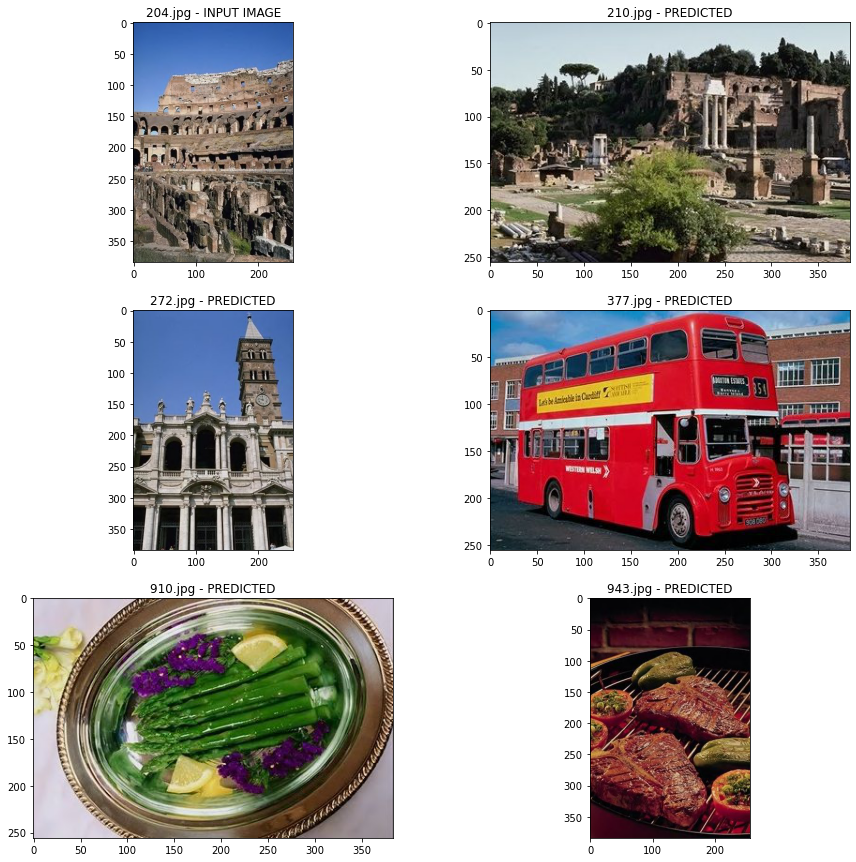

In [58]:
visualize_results(dict_predictions_test['204.jpg'], '204.jpg')

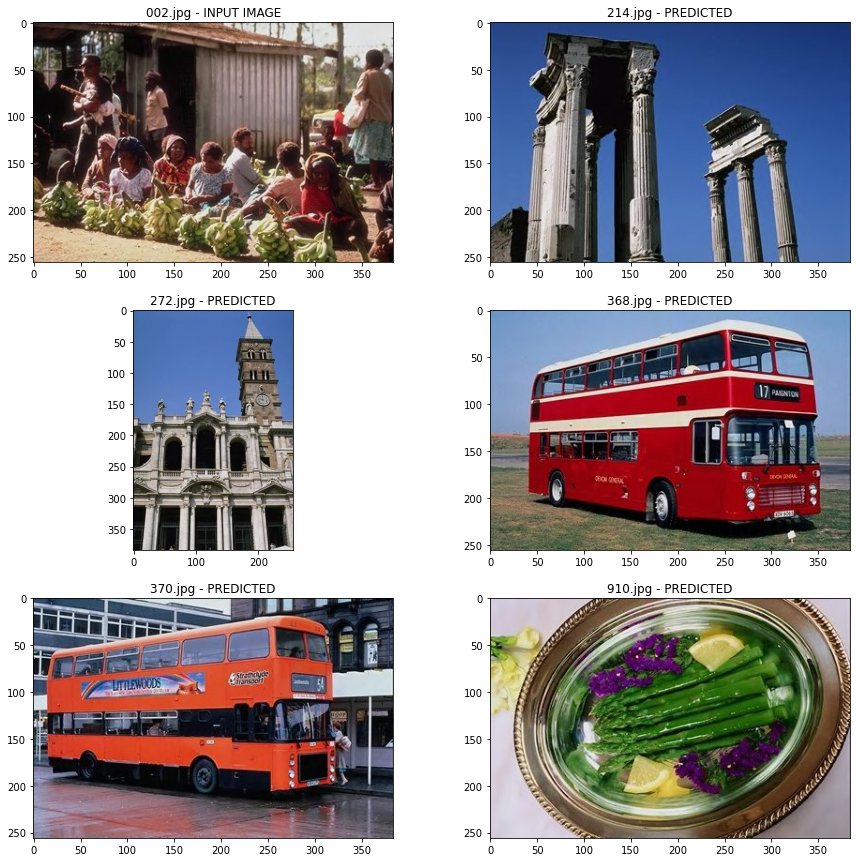

In [59]:
visualize_results(dict_predictions_test['002.jpg'], '002.jpg')

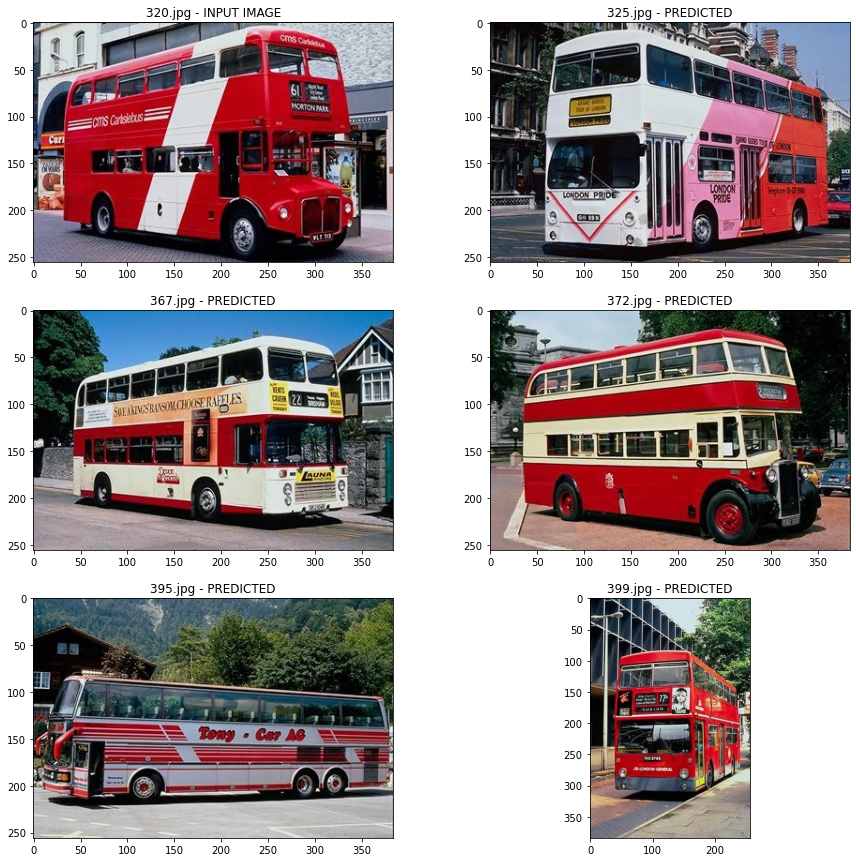

In [61]:
visualize_results(dict_predictions_test['321.jpg'], '320.jpg')